<a href="https://colab.research.google.com/github/EnesEmek26/Algoritm_odevlerim/blob/main/Enes_Emek_2212101042.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Bölüm Veri seti ve Gerekli Kütüphanelerin indirilmesi

Aşağıdaki kod bloğunda derin öğrenme tabanlı segmantasyon modeli için gerekli olan kütüphanlerin çalışma ortamına entegrasyonu yapılmıştır.

In [1]:

!pip install -q segmentation-models kaggle albumentations scikit-image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.4 MB/s eta 0:00:00


In [2]:
!pip install segmentation-models


Aşağıdaki kod bloğunda çalışmada kullanılacak olan NuSeC veri setinin kagle apisi kullananılarak indirlmesi ve zipten çıkartılarak kullanibilir hale getirilmesi sağlanmıştır.

In [3]:
from google.colab import files
import os

uploaded = files.upload()
for fname in uploaded.keys():
    if fname.endswith('.json'):
        os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
        os.replace(fname, os.path.expanduser('~/.kaggle/kaggle.json'))
        os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)


!kaggle datasets download -d sonianmty/nusec-and-midesec -p /content/nusec_data
!mkdir -p /content/nusec_data
!unzip -q /content/nusec_data/nusec-and-midesec.zip -d /content/nusec_data


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/sonianmty/nusec-and-midesec
License(s): other
 98% 374M/383M [00:04<00:00, 74.2MB/s]
100% 383M/383M [00:04<00:00, 97.0MB/s]


#2.Bölüm Kütüphanlerin İçeri Aktarılması ve Veri Artırma Hattı

Aşağıdaki kod bloğunda modelin eğitim süreci için kullanılacak olan temel kütüphanler projeye dahil edilmiştir. Derin öğrenme modelini eğitmini iyileştirmek için görüntü çoğaltma hattı oluşturuldu. Bu hatta eğitim verisi üzerinde döndürme , yanıstma ve parlaklık değişimleri gibi geometrik ve piksel tabanlı dönüşümler uygulanarak mikroskop altında farklı parlaklık ve rotasyondaki verileri de düzgün bir şekilde işlenmesi sağlanmıştır.

In [4]:
import os
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import tensorflow as tf
import keras
keras.utils.generic_utils = tf.keras.utils
import segmentation_models as sm
from skimage.measure import label
from PIL import Image
import cv2

keras.utils.generic_utils = tf.keras.utils

import segmentation_models as sm
from skimage.measure import label


sm.set_framework('tf.keras')



base_dir = '/content/nusec_data/Ankara University Datasets/NuSeC'
train_img_dir = os.path.join(base_dir, 'train nuclei')
train_mask_dir = os.path.join(base_dir, 'mask of train nuclei')
val_img_dir = os.path.join(base_dir, 'test nuclei')
val_mask_dir = os.path.join(base_dir, 'mask of test nuclei')


train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


Segmentation Models: using `keras` framework.


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# 3.Bölüm Veri Üretici Fonksiyonu

Aşağıdaki kod bloğunda bellek yönetimi ve verimlilik açısından tüm veriyi aynı anda RAM e yüklemek yerine verileri parti parti işleyen bir üretici fonksiyonu yapıldı.Bu fonskiyon önemli 3 tane ön işleme adımını da gerçekleştiriyor. ilk olarak görüntü okuma ve boyutlandırma yaparak modelin giriş katmanına uygun olan 512x512 piksel boyutuna ölçeklendirme yapmaktadır.Veri seti üzerinde verilen maskelerin her hücre için ayrı ayrı olarak verilmiş maskeleri arka plan ve hücrenin çekirdekleri olarak anlamsal bölütleme (sematic segmantation) için uygun hale getirmektedir.son olarak verilerin görüntü piksellerini 0-1 aralığına getirerek modelin ağırlık optimizasyonu daha kararlı hale gelmesine fayda sağlamıştır.

In [5]:
def create_generator(image_dir, mask_dir, batch_size=4, img_size=(512, 512), augment=False, preprocess=None):
    image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.tif')]

    transforms = A.Compose([
        A.Rotate(limit=45, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
    ])

    def generator():
        while True:
            np.random.shuffle(image_filenames)
            for i in range(0, len(image_filenames), batch_size):
                batch_files = image_filenames[i:i+batch_size]
                images, masks = [], []

                for filename in batch_files:
                    img_path = os.path.join(image_dir, filename)
                    mask_path = os.path.join(mask_dir, filename)

                    img = np.array(Image.open(img_path).convert('RGB'))
                    mask = np.array(Image.open(mask_path))

                    if mask.ndim == 3:
                        mask = np.max(mask, axis=2)

                    mask = (mask > 0).astype(np.float32)

                    img = cv2.resize(img, img_size)
                    mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)

                    if augment:
                        aug = transforms(image=img, mask=mask)
                        img, mask = aug['image'], aug['mask']

                    if preprocess:
                        img = preprocess(img)
                    else:
                        img = img / 255.0

                    mask = np.expand_dims(mask, axis=-1)

                    images.append(img)
                    masks.append(mask)

                yield np.array(images), np.array(masks)

    return generator()


#4.Bölüm Özel AJI Metriği ve Model Kayıt (Callback) Mekanizması

Aşağıdaki kod bloğunda keras kütüphanesi içerisinde olmayan AJI(Aggregated Jaccard Index) metriğini hesaplamasını yapan sınıf oluşturulmuştur.Bu metrik kullanarak modelin hücre segmentasyon başarımının doğruluk(accuracy) ve kayıp(loss) değerlerinden daha verimli şekilde ölçülmesi içni kullanılmıştır.

In [6]:
class AJICheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, val_gen, steps, save_path):
        super().__init__()
        self.val_gen = val_gen
        self.steps = steps
        self.save_path = save_path
        self.best_aji = -1

    def on_epoch_end(self, epoch, logs=None):
        total_aji = 0
        count = 0

        for _ in range(self.steps):
            x_val, y_val = next(self.val_gen)
            preds = (self.model.predict(x_val, verbose=0) > 0.5).astype(np.uint8)
            y_val = y_val.astype(np.uint8)

            for j in range(len(x_val)):
                aji = get_fast_aji(y_val[j].squeeze(), preds[j].squeeze())
                total_aji += aji
                count += 1

        avg_aji = total_aji / count
        print(f"\nEpoch {epoch+1} - Validation AJI Score: {avg_aji:.4f}")

        if logs is not None:
            logs['val_aji'] = avg_aji

        if avg_aji > self.best_aji:
            print(f"AJI improved from {self.best_aji:.4f} to {avg_aji:.4f}. Saving model...")
            self.best_aji = avg_aji
            self.model.save(self.save_path)


In [7]:
def get_fast_aji(true_mask, pred_mask):
    true_mask = np.array(true_mask)
    pred_mask = np.array(pred_mask)

    true_labels = label(true_mask)
    pred_labels = label(pred_mask)

    true_objects = [true_labels == i for i in range(1, true_labels.max() + 1)]
    pred_objects = [pred_labels == i for i in range(1, pred_labels.max() + 1)]

    used_pred_indices = set()
    intersection_sum, union_sum = 0, 0

    for true_obj in true_objects:
        best_iou = 0
        best_pred_idx = -1

        overlap_indices = np.unique(pred_labels[true_obj])
        overlap_indices = overlap_indices[overlap_indices > 0]

        for pred_idx in overlap_indices:
            if pred_idx in used_pred_indices:
                continue

            pred_obj = (pred_labels == pred_idx)
            intersection = np.logical_and(true_obj, pred_obj).sum()
            union = np.logical_or(true_obj, pred_obj).sum()

            iou = intersection / union

            if iou > best_iou:
                best_iou = iou
                best_pred_idx = pred_idx

        if best_pred_idx != -1:
            pred_obj = (pred_labels == best_pred_idx)
            intersection = np.logical_and(true_obj, pred_obj).sum()
            union = np.logical_or(true_obj, pred_obj).sum()

            intersection_sum += intersection
            union_sum += union

            used_pred_indices.add(best_pred_idx)
        else:
            union_sum += true_obj.sum()


    for i in range(1, pred_labels.max() + 1):
        if i not in used_pred_indices:
            union_sum += (pred_labels == i).sum()


    return intersection_sum / union_sum if union_sum != 0 else 0.0


# 5. Bölüm: U-Net Mimarisi ve Eğitimin Başlatılması

Aşağıdaki kod bloğunda biyomedikal görüntü segmantasyonu başarısı kanıtlanmış olan U-Net mimarisi tercih edilmiştir.Modelin özellik çıkarıcı (Encoder) kısmında, Transfer Öğrenmesi(Transfer Learning) yönteminden faydalınalarak ImageNet veri seti üzerinde önceden eğitilmiş ResNet32 mimarisi kullanılmıştır. Modelin optimizasyonu için sınıf dengesizliğini(class inbalance) sorunun ele alan dice loss ve focal loss kombinasyonu kullanılmıştır.Eğitim sürecinde aşırı öğrenmeyi engellemek adına doğrulama setindeki performansa dayalı olarak öğrenme oranı(learning rate) düşüren ReduceLROnPlateau geri çağrımı ile desteklenmiştir.

In [8]:

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)


train_gen = create_generator(
    train_img_dir,
    train_mask_dir,
    batch_size=4,
    img_size=(512, 512),
    augment=True,
    preprocess=preprocess_input
)


val_gen_fit = create_generator(
    val_img_dir,
    val_mask_dir,
    batch_size=4,
    img_size=(512, 512),
    augment=False,
    preprocess=preprocess_input
)


val_gen_aji = create_generator(
    val_img_dir,
    val_mask_dir,
    batch_size=4,
    img_size=(512, 512),
    augment=False,
    preprocess=preprocess_input
)

train_steps = int(np.ceil(len(os.listdir(train_img_dir)) / 4))
val_steps   = int(np.ceil(len(os.listdir(val_img_dir))   / 4))


model = sm.Unet(
    BACKBONE,
    encoder_weights='imagenet',
    classes=1,
    activation='sigmoid'
)


dice_loss  = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + focal_loss

metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(threshold=0.5, name='dice_score')
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=total_loss,
    metrics=metrics
)


callbacks = [
    AJICheckpoint(val_gen_aji, val_steps, 'best_model_aji.keras'),

    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    ),

    tf.keras.callbacks.ModelCheckpoint(
        'best_model_dice.keras',
        monitor='val_dice_score',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=100,
    validation_data=val_gen_fit,
    validation_steps=val_steps,
    callbacks=callbacks
)


85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice_score: 0.3222 - iou_score: 0.1934 - loss: 0.8205   
Epoch 1 - Validation AJI Score: 0.0052
AJI improved from -1.0000 to 0.0052. Saving model...

Epoch 1: val_dice_score improved from -inf to 0.35172, saving model to best_model_dice.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 162s 5s/step - dice_score: 0.3244 - iou_score: 0.1950 - loss: 0.8196 - val_dice_score: 0.3517 - val_iou_score: 0.2148 - val_loss: 0.8309 - val_aji: 0.0052 - learning_rate: 1.0000e-04
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - dice_score: 0.5113 - iou_score: 0.3453 - loss: 0.7272
Epoch 2 - Validation AJI Score: 0.0113
AJI improved from 0.0052 to 0.0113. Saving model...

Epoch 2: val_dice_score improved from 0.35172 to 0.44407, saving model to best_model_dice.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - dice_score: 0.5134 - iou_score: 0.3473 - loss: 0.7257 - val_dice_score: 0.4441 - val_iou_score: 0.2862 - v

# 7. Bölüm: Sonuçların Görselleştirilmesi

Eğitim sürecinin kararlılığını ve modelin başarısını analiz etmek amacıyla, eğitim ve doğrulama kümeleri üzerindeki kayıp (loss), Dice katsayısı, IOU (Intersection over Union) ve AJI skorları görselleştirilmiştir. Bu grafikler, modelin öğrenme dinamiklerini, olası 'overfitting' (aşırı öğrenme) durumlarını ve modelin genelleştirme kapasitesini değerlendirmek için kullanılmıştır.

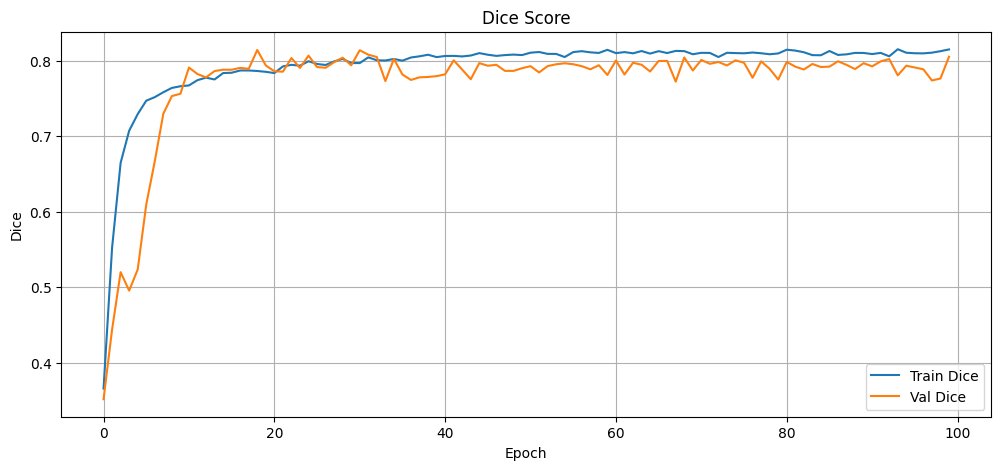

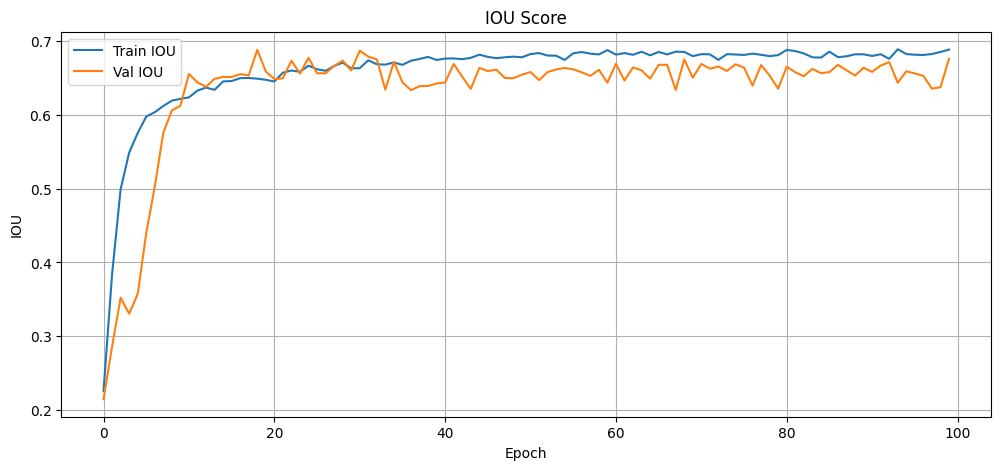

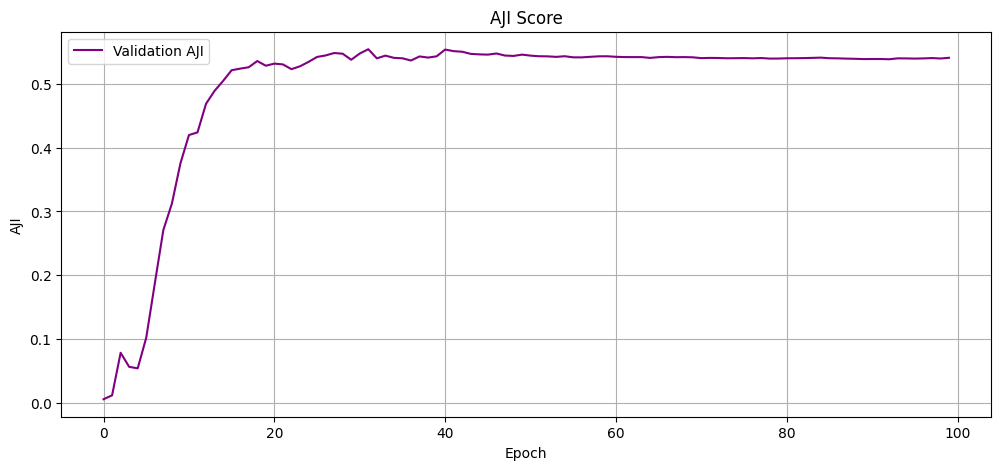

In [9]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12,5))
plt.plot(history.history['dice_score'], label='Train Dice')
plt.plot(history.history['val_dice_score'], label='Val Dice')
plt.title("Dice Score")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12,5))
plt.plot(history.history['iou_score'], label='Train IOU')
plt.plot(history.history['val_iou_score'], label='Val IOU')
plt.title("IOU Score")
plt.xlabel("Epoch")
plt.ylabel("IOU")
plt.legend()
plt.grid(True)
plt.show()

if 'val_aji' in history.history:
    plt.figure(figsize=(12,5))
    plt.plot(history.history['val_aji'], label='Validation AJI', color='purple')
    plt.title("AJI Score")
    plt.xlabel("Epoch")
    plt.ylabel("AJI")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("History'de val_aji bulunamadı! AJICheckpoint doğru çalışmamış olabilir.")


Eğitilen modelin nitel (qualitative) performansını değerlendirmek amacıyla, doğrulama setinden rastgele seçilen örnekler üzerinde tahminleme (inference) yapılmıştır. Orijinal mikroskobik görüntü, uzmanlar tarafından işaretlenmiş gerçek maske (Ground Truth) ve modelin ürettiği tahmin maskesi yan yana görselleştirilerek, modelin hücre sınırlarını ne kadar hassas tespit edebildiği analiz edilmiştir.

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


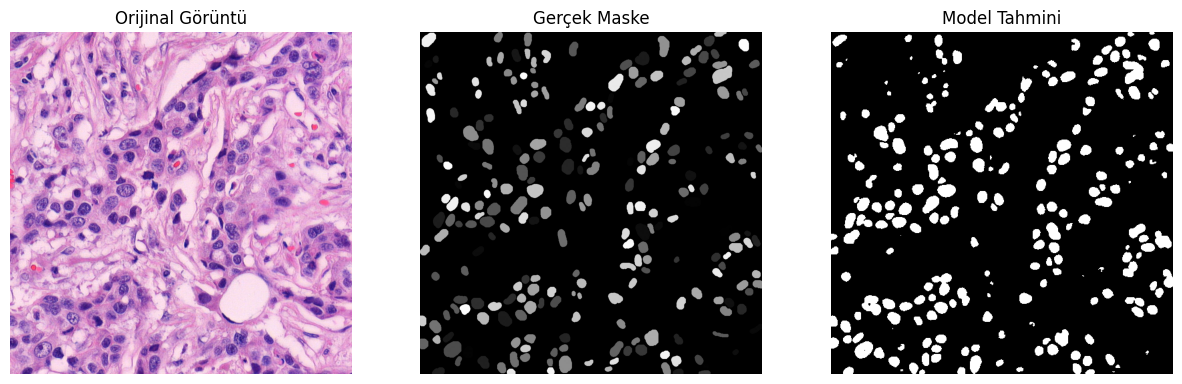

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


sample_file = os.listdir(val_img_dir)[0]
img_path = os.path.join(val_img_dir, sample_file)
mask_path = os.path.join(val_mask_dir, sample_file)


img = np.array(Image.open(img_path).convert("RGB"))
mask = np.array(Image.open(mask_path))
if mask.ndim == 3:
    mask = np.max(mask, axis=2)


img_resized = cv2.resize(img, (512, 512))
input_img = preprocess_input(img_resized.astype(np.float32))

# Model tahmini
pred = model.predict(np.expand_dims(input_img, axis=0))[0]
pred_mask = (pred > 0.5).astype(np.uint8).squeeze()


plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Orijinal Görüntü")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask, cmap='gray')
plt.title("Gerçek Maske")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap='gray')
plt.title("Model Tahmini")
plt.axis("off")

plt.show()
